In [ ]:
#import any libraries we need
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

In [ ]:
#reads in the dataset
data = pd.read_csv("/content/TylerTheCreatorDF.csv")
#prints first five rows of the dataset
data.head()

chroma_df = pd.read_csv("/content/tyler_chromakopia_df.csv")
chroma_df = chroma_df[chroma_df['album_name'] == 'CHROMAKOPIA']

In [ ]:
#displays summary statistics for each feature in the dataset
data.describe()

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration,year,featured_artists_count,Streams,Daily,Years since release,Yearly Stream
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,1.010000e+02,1.010000e+02,101.000000,1.010000e+02
mean,59.485149,0.549277,0.635901,-7.868406,0.236791,0.202708,0.048513,0.319295,0.446594,109.230406,3.930693,219.059406,2016.504950,0.732673,1.379826e+08,1.310600e+05,7.495050,2.893772e+07
std,10.536236,0.132921,0.143730,2.424160,0.151889,0.219273,0.177034,0.223709,0.192871,32.593925,0.430289,98.817997,3.933507,1.121527,2.450551e+08,3.185572e+05,3.933507,4.601316e+07
min,40.000000,0.216000,0.271000,-14.841000,0.027500,0.000063,0.000000,0.047600,0.064800,40.319000,1.000000,36.000000,2011.000000,0.000000,5.966566e+06,2.949000e+03,1.000000,5.336855e+05
25%,52.000000,0.458000,0.539000,-9.473000,0.095900,0.030200,0.000000,0.140000,0.297000,80.355000,4.000000,161.000000,2013.000000,0.000000,2.654807e+07,1.654600e+04,4.000000,2.632821e+06
50%,60.000000,0.547000,0.634000,-7.869000,0.241000,0.121000,0.000007,0.243000,0.455000,97.672000,4.000000,206.000000,2017.000000,0.000000,5.646988e+07,4.121700e+04,7.000000,1.395671e+07
75%,66.000000,0.638000,0.744000,-6.290000,0.355000,0.329000,0.000930,0.478000,0.584000,137.131000,4.000000,248.000000,2020.000000,1.000000,1.488889e+08,9.665000e+04,11.000000,3.067862e+07
max,89.000000,0.827000,0.932000,-2.389000,0.828000,0.959000,0.947000,0.890000,0.880000,187.308000,5.000000,588.000000,2023.000000,7.000000,1.935908e+09,2.720762e+06,13.000000,2.765583e+08


In [ ]:
#added features

data['dance_factor'] = (
        (data['valence'] * data['tempo'] * data['instrumentalness']) /
        (data['speechiness'])
        )

data['live_concert_energy'] = (
        data['liveness'] *
        data['acousticness'] *
        (1 / (data['speechiness']))
    )

data['production_complexity'] = (
        data['instrumentalness'] +
        (1 - data['acousticness']) +
        (data['time_signature'] / 4)
    )

data['human_touch_factor'] = (
        (1 - data['instrumentalness']) *
        (1 - data['speechiness']) *
        data['acousticness']
    )

data['feel_good_index'] = (
        (data['valence'] * data['tempo'] * data['duration'])
    )

chroma_df['dance_factor'] = (
        (chroma_df['valence'] * chroma_df['tempo'] * chroma_df['instrumentalness']) /
        (chroma_df['speechiness'])
        )

chroma_df['live_concert_energy'] = (
        chroma_df['liveness'] *
        chroma_df['acousticness'] *
        (1 / (chroma_df['speechiness']))
    )

chroma_df['production_complexity'] = (
        chroma_df['instrumentalness'] +
        (1 - chroma_df['acousticness']) +
        (chroma_df['time_signature'] / 4)
    )

chroma_df['human_touch_factor'] = (
        (1 - chroma_df['instrumentalness']) *
        (1 - chroma_df['speechiness']) *
        data['acousticness']
    )

In [ ]:
# principal component analysis - applying pca and extracting the loadings

pca_features = ['loudness', 'acousticness', 'liveness', 'danceability']

X = data.copy()
y = X.pop('Yearly Stream')
X = X.loc[:, pca_features]

# standardize X
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

# create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(X_pca, columns = component_names)

# extract loadings
loadings = pd.DataFrame(pca.components_.T, columns = component_names, index = X.columns)
loadings

,PC1,PC2,PC3,PC4
loudness,0.261928,-0.689513,0.631471,-0.239186
acousticness,0.205665,0.706910,0.676186,-0.027438
liveness,0.677406,-0.079702,-0.093281,0.725305
danceability,-0.655909,-0.136005,0.367853,0.644957


In [ ]:
# principal component analysis - using the loadings to create new features

# loudness, acousticness
data['LoudToAcoustic'] = data.loudness * data.acousticness

# liveness, danceability
data['LivenessTimesDance'] = data.liveness * data.danceability

# loudness, acousticness
chroma_df['LoudToAcoustic'] = chroma_df.loudness * chroma_df.acousticness

# liveness, danceability
chroma_df['LivenessTimesDance'] = chroma_df.liveness * chroma_df.danceability

In [ ]:
X = data.copy()
y = X.pop("Yearly Stream")

# label encoding for categoricals
for colname in X.select_dtypes("object"):
  X[colname], _ = X[colname].factorize()

# use mutual info regression to get mi scores
mi_scores = mutual_info_regression(X, y, discrete_features = 'auto')
mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X.columns).sort_values(ascending = False)

# print out all values
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.6f}'.format)

mi_scores

,MI Scores
Streams,1.066602
Daily,0.779009
popularity,0.708168
year,0.557228
Years since release,0.546124
track_id,0.522165
track_name,0.511902
album_id,0.504539
album_name,0.473888
release_date,0.464248


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   artist_name             101 non-null    object 
 1   track_name              101 non-null    object 
 2   track_id                101 non-null    object 
 3   album_name              101 non-null    object 
 4   album_id                101 non-null    object 
 5   release_date            101 non-null    object 
 6   popularity              101 non-null    int64  
 7   explicit                101 non-null    bool   
 8   danceability            101 non-null    float64
 9   energy                  101 non-null    float64
 10  key                     101 non-null    object 
 11  loudness                101 non-null    float64
 12  mode                    101 non-null    object 
 13  speechiness             101 non-null    float64
 14  acousticness            101 non-null    fl

In [ ]:
#define the features and the target variable
features = ['album_name', 'danceability',
            'energy', 'key', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'type',
            'duration', 'month', 'day_of_the_week', 'LoudToAcoustic',
            'LivenessTimesDance', 'live_concert_energy',
            'human_touch_factor']
target = 'Yearly Stream'

In [ ]:
#gives us the dataset copy with only the features we want to use
data_subset = data[features + [target]].copy()

chroma_subset = chroma_df[features].copy()

In [ ]:
#encodes the categorical features
categorical_features = ['album_name', 'key', 'mode', 'type', 'month', 'day_of_the_week']
label_encoders = {col: LabelEncoder() for col in categorical_features}
for col in categorical_features:
  data_subset[col] = data_subset[col].apply(lambda x: str(x) if not pd.isnull(x) else 'Unknown')
  data_subset[col] = label_encoders[col].fit_transform(data_subset[col].astype(str))

label_encoders = {col: LabelEncoder() for col in categorical_features}
for col in categorical_features:
  chroma_subset[col] = chroma_subset[col].apply(lambda x: str(x) if not pd.isnull(x) else 'Unknown')
  chroma_subset[col] = label_encoders[col].fit_transform(chroma_subset[col].astype(str))

In [ ]:
#separate the target and features into their own subsets
X = data_subset[features]
y = data_subset[target]

chroma_X = chroma_subset[features]

In [ ]:
#scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

chroma_X = scaler.fit_transform(chroma_X)

In [ ]:
#split and train the testing and training data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20, random_state = 42)

In [ ]:
#now train each regressor machine learning models and make predictions
regressor_models = {
    "Random Forest Regressor": RandomForestRegressor(random_state = 42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state = 42),
    "Decision Trees Regressor": DecisionTreeRegressor(random_state = 42),
    "Linear Regression": LinearRegression()
}
#print out the performance of each model
#regressor models work much better which lines up with the target feature that we are using
#The top two model that has the best perforamnce is the Random Forest Regressor and the Gradient Boosting Regressor
regressor_model_performance = {}
for regressor_model_name, regressor_model in regressor_models.items():
  regressor_model.fit(X_train, y_train)
  y_pred = regressor_model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  regressor_model_performance[regressor_model_name] = {"MSE": mse, "R2 Score": r2}
  print(f"{regressor_model_name} Performance:")
  print(f"  Mean Squared Error (MSE): {mse}")
  print(f"  R² Score: {r2}")
  print("="*40)

Random Forest Regressor Performance:
  Mean Squared Error (MSE): 1954663283588838.5
  R² Score: -0.029535172413972743
Gradient Boosting Regressor Performance:
  Mean Squared Error (MSE): 1871743764269334.8
  R² Score: 0.01413913319960014
Decision Trees Regressor Performance:
  Mean Squared Error (MSE): 1631918504378030.0
  R² Score: 0.14045681786909814
Linear Regression Performance:
  Mean Squared Error (MSE): 2173809521178052.2
  R² Score: -0.14496106770476658


In [ ]:
#print out the feature importance of the Random Forest Regressor model
#shows how important each feature was to the performance of the Random Forest Regressor model
rfreg_importances = regressor_models["Random Forest Regressor"].feature_importances_
rfreg_feature_importance = pd.DataFrame({'RandomForestRegressor Features': features, 'RandomForestRegressor Importance': rfreg_importances}).sort_values(by = 'RandomForestRegressor Importance', ascending = False)
print(rfreg_feature_importance)
print("="*80)
#print out the feature importance of the Gradient Boosting Regressor model
#shows how important each feature was to the performance of the Gradient Boosting Regressor model
gbreg_importances = regressor_models["Gradient Boosting Regressor"].feature_importances_
gbreg_feature_importance = pd.DataFrame({'GradientBoostingRegressor Features': features, 'GradientBoostingRegressor Importance': gbreg_importances}).sort_values(by = 'GradientBoostingRegressor Importance', ascending = False)
print(gbreg_feature_importance)


   RandomForestRegressor Features  RandomForestRegressor Importance
15            live_concert_energy                          0.198453
12                day_of_the_week                          0.125189
5                     speechiness                          0.102559
0                      album_name                          0.089516
8                        liveness                          0.070739
13                 LoudToAcoustic                          0.057898
14             LivenessTimesDance                          0.056462
10                       duration                          0.045827
3                             key                          0.042007
6                    acousticness                          0.039325
1                    danceability                          0.038062
16             human_touch_factor                          0.032089
9                            type                          0.029590
2                          energy               

In [ ]:
#collect all the numerical features of our dataset
numerical_features = ['explicit', 'danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                    'time_signature', 'duration', 'year', 'Streams', 'Daily']

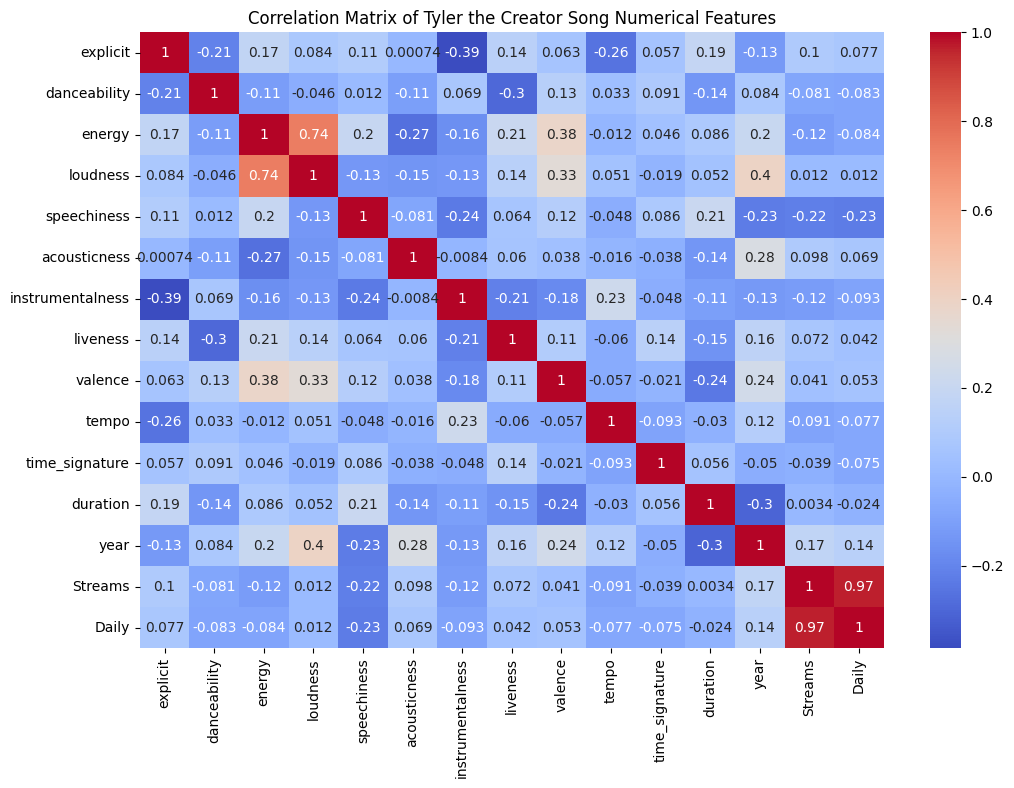

In [ ]:
#display the correlation matrix between the numerical features
#this can show us how related each feature is towards each other
#we want the features with the higher correlation to each other so that it has relevance with our data and will improve our model
corr_matrix = data[numerical_features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Tyler the Creator Song Numerical Features')
plt.show()

In [ ]:
model = RandomForestRegressor(random_state = 42)
model.fit(X_train, y_train)
chroma_pred = pd.DataFrame(model.predict(chroma_X))

chroma_pred.index = chroma_df.track_name
chroma_pred.columns = ['Predicted Yearly Streams']

pd.options.display.float_format = '{:.0f}'.format
chroma_pred

,Predicted Yearly Streams
track_name,
Thought I Was Dead (feat. ScHoolboy Q & Santigold),69694024
Noid,41752361
St. Chroma (feat. Daniel Caesar),32245537
I Killed You,15339509
Tomorrow,89363486
Judge Judy,34054753
Like Him (feat. Lola Young),121021855
Take Your Mask Off (feat. Daniel Caesar & LaToiya Williams),46518459
I Hope You Find Your Way Home,65033450


In [ ]:
data[['track_name', 'Yearly Stream']]

,track_name,Yearly Stream
0,435,10563927
1,BEST INTEREST,158086051
2,WUSYANAME (feat. Youngboy Never Broke Again & ...,122676444
3,SWEET / I THOUGHT YOU WANTED TO DANCE (feat. B...,101464451
4,SIR BAUDELAIRE (feat. DJ Drama),30085264
5,JUGGERNAUT (feat. Lil Uzi Vert & Pharrell Will...,49907260
6,HOT WIND BLOWS (feat. Lil Wayne),45506668
7,RUNITUP (feat. Teezo Touchdown),26406330
8,CORSO,38686422
9,RISE! (feat. DAISY WORLD),19927759
